In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma, lognorm
from scipy.integrate import cumulative_trapezoid
import time
import pickle

from joblib import Parallel, delayed, cpu_count

from efficient_fpt.models import DDModel, piecewise_const_func
from efficient_fpt.utils import get_alternating_mu_array

In [2]:
class aDDModel(DDModel):
    """
    One trial of an attentional drift diffusion model with alternating drift mu1 and mu2.
    """
    def __init__(self, mu1, mu2, sacc_array, flag, sigma, a, b, x0):
        super().__init__(x0)
        # drift parameters
        self.mu1 = mu1
        self.mu2 = mu2
        self.sacc_array = sacc_array
        self.flag = flag # indicates whether the process starts with mu1 (flag=0) or mu2 (flag=1)
        self.d = len(sacc_array) # number of stages
        self.mu_array = get_alternating_mu_array(mu1, mu2, self.d, flag)
        # diffusion parameter
        self.sigma = sigma
        # symmetric linear boundary parameters
        self.a = a
        self.b = b

    def drift_coeff(self, X: float, t: float) -> float:
        return piecewise_const_func(t, self.mu_array, self.sacc_array)

    def diffusion_coeff(self, X: float, t: float) -> float:
        return self.sigma

    @property
    def is_update_vectorizable(self) -> bool:
        return True

    def upper_bdy(self, t: float) -> float:
        return self.a - self.b * t

    def lower_bdy(self, t: float) -> float:
        return -self.a + self.b * t

In [3]:
# num_samples = 10000
# rng = np.random.default_rng()
# # sample lognormal waiting times and visualize
# mu = 6.39
# sigma = 0.63
# waitTs1 = rng.lognormal(mean=mu, sigma=sigma, size=num_samples) / 2000

# # sample gamma waiting times and visualize
# shape_param = 8 
# scale_param = 0.2
# waitTs2 = rng.gamma(shape_param, scale_param, num_samples)


# fig, ax = plt.subplots(figsize=(10, 4))
# x = np.linspace(0, max(np.max(waitTs1), np.max(waitTs2)), 2000)
# ax.plot(x, lognorm.pdf(x, s=sigma, scale=np.exp(mu + np.log(1 / 2000))), "r", alpha=0.6, label="lognorm pdf")
# ax.plot(x, lognorm.pdf(x / np.exp(mu + np.log(1 / 2000)), s=sigma) / np.exp(mu + np.log(1 / 2000)), "pink", alpha=0.6, label="lognorm pdf")
# ax.hist(waitTs1, histtype="step", bins=40, color="red", density=True, label="histogram")
# ax.plot(x, gamma.pdf(x, a=shape_param, scale=scale_param), "b", alpha=0.6, label="gamma pdf")
# ax.hist(waitTs2, histtype="step", bins=40, color="blue", density=True, label="histogram")
# ax.autoscale(tight=True, axis="x")
# ax.set_aspect("equal")
# ax.legend()
# plt.show()

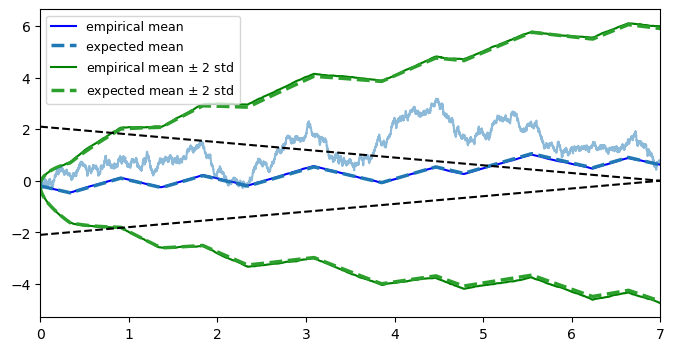

In [4]:
mu1, mu2 = 1.0, -0.8
a, b = 2.1, 0.3
T = a / b
x0 = -0.2

shape_param, scale_param = 6, 0.1
rng = np.random.default_rng()
fixations = rng.gamma(shape_param, scale_param, 1000)
sacc_array = np.insert(np.cumsum(fixations), 0, 0)
sacc_array = sacc_array[sacc_array < T]
flag = np.random.binomial(1, 0.5)
sigma = 1
num = 2000

ddm = aDDModel(mu1=mu1, mu2=mu2, sacc_array=sacc_array, flag=flag, sigma=sigma, a=a, b=b, x0=x0)
t_grid, X_grids = ddm.simulate_trajs(T=T, Nt=1000 * T, num=num)

expected_mean = cumulative_trapezoid(ddm.drift_coeff(_, t_grid), t_grid, initial=0) + x0
empirical_mean = np.mean(X_grids, axis=0)
expected_std = ddm.sigma * np.sqrt(t_grid)
empirical_std = np.std(X_grids, axis=0)


fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(t_grid, empirical_mean, label="empirical mean", c="b")
ax.plot(t_grid, expected_mean, label="expected mean", linewidth=2.5, linestyle="--", c="tab:blue")
ax.plot(t_grid, empirical_mean + 2 * empirical_std, label=r"empirical mean $\pm$ 2 std", c="g")
ax.plot(t_grid, empirical_mean - 2 * empirical_std, c="g")
ax.plot(t_grid, expected_mean + 2 * expected_std, label=r"expected mean $\pm$ 2 std", linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, expected_mean - 2 * expected_std, linewidth=2.5, linestyle="--", c="tab:green")
ax.plot(t_grid, X_grids[:1, :].T, alpha=0.5)
ax.plot(t_grid, ddm.upper_bdy(t_grid), c='k', linestyle="--")
ax.plot(t_grid, ddm.lower_bdy(t_grid), c='k', linestyle="--")
ax.autoscale(axis="x", tight=True)
ax.legend(fontsize=9)
plt.show()

In [5]:
# num_data = 5
# decision_data = np.zeros((num_data, 2))
# mu_data = []
# sacc_data = []

# for n in range(num_data):
#     if n % 100 == 0:
#         print(n, end=' ')
#     fixations = rng.gamma(shape_param, scale_param, 1000)
#     sacc_array = np.insert(np.cumsum(fixations), 0, 0)
#     sacc_array = sacc_array[sacc_array < T]
#     flag = np.random.binomial(1, 0.5)
#     addm = aDDModel(mu1=mu1, mu2=mu2, sacc_array=sacc_array, flag=flag, sigma=sigma, a=a, b=b, x0=x0)
#     decision_data[n] = addm.simulate_fpt_datum(dt=0.0001)
#     sacc_array = sacc_array[sacc_array < decision_data[n, 0]]
#     d = len(sacc_array)
#     mu_array = get_alternating_mu_array(mu1, mu2, d, flag)
#     mu_data.append(mu_array)
#     sacc_data.append(sacc_array)

In [6]:
num_data = 100000
decision_data = np.zeros((num_data, 2))
mu_data = [None] * num_data
sacc_data = [None] * num_data

def simulate_trial(n, mu1, mu2, sigma, a, b, T, x0, shape_param, scale_param):
    rng = np.random.default_rng()
    fixations = rng.gamma(shape_param, scale_param, 1000)
    sacc_array = np.insert(np.cumsum(fixations), 0, 0)
    sacc_array = sacc_array[sacc_array < T]
    
    flag = rng.binomial(1, 0.5)
    addm = aDDModel(mu1=mu1, mu2=mu2, sacc_array=sacc_array, flag=flag, sigma=sigma, a=a, b=b, x0=x0)
    decision = addm.simulate_fpt_datum(dt=1e-5)

    sacc_array = sacc_array[sacc_array < decision[0]]
    d = len(sacc_array)
    mu_array = get_alternating_mu_array(mu1, mu2, d, flag)

    return decision, mu_array, sacc_array

print("Available jobs (CPU cores):", cpu_count())

start_time = time.time()
results = Parallel(n_jobs=-1)(
    delayed(simulate_trial)(n, mu1, mu2, sigma, a, b, T, x0, shape_param, scale_param)
    for n in range(num_data)
)
print(f"Elapsed time: {time.time() - start_time:.3f} seconds")


# Store results
for n, (decision, mu_array, sacc_array) in enumerate(results):
    decision_data[n] = decision
    mu_data[n] = mu_array
    sacc_data[n] = sacc_array

Available jobs (CPU cores): 64
Elapsed time: 7872.459 seconds


In [7]:
d_data = np.array([len(mu_array) for mu_array in mu_data])
min_len, max_len, avg_len = np.min(d_data), np.max(d_data), np.mean(d_data)
min_len, max_len, avg_len

(1, 13, 3.93359)

In [8]:
# the minimum fixation time
min_fixations = [np.min(np.diff(sacc_array)) for sacc_array in sacc_data if len(sacc_array) > 1]
print(min(min_fixations))

0.04251182859400571


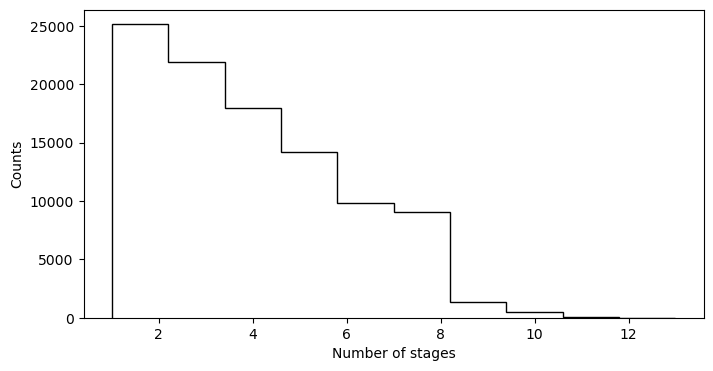

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(d_data, histtype="step", color="k")
ax.set_xlabel("Number of stages")
ax.set_ylabel("Counts")
plt.show()

padded each data to maximum length for uniform storage

the effective length (i.e. before padding) satisfies `length(mu_array[i]) = length(sacc_array[i]) = d`, so after padding `length(mu_array_padded[i]) = length(t_array_padded[i]) = maxLen`

In [10]:
mu_data_padded = np.array([np.pad(mu_array, (0, max_len - len(mu_array)), mode='constant') for mu_array in mu_data])
sacc_data_padded = np.array([np.pad(sacc_array, (0, max_len - len(sacc_array)), mode='constant') for sacc_array in sacc_data])


In [11]:
data_to_save = {
    'mu_data_padded': mu_data_padded,
    'sacc_data_padded': sacc_data_padded,
    'd_data': d_data,
    'decision_data': decision_data,
    'mu1': mu1,
    'mu2': mu2,
    'sigma': sigma,
    'a': a,
    'b': b,
    'x0': x0,
    'T': T,
    'gamma_shape_param': shape_param,
    'gamma_scale_param': scale_param
}
fname = "addm_data_" + time.strftime("%Y%m%d-%H%M%S") + ".pkl"
with open(fname, "wb") as f:
    pickle.dump(data_to_save, f)